In [25]:
import igl
import numpy as np
import networkx as nx
import drawSvg as draw
import meshplot as mp
mp.jupyter()

def add_edges_from_mesh(graph, faces):
    face_adjacency_matrix, _ = igl.triangle_triangle_adjacency(faces)
    for face_id, _ in enumerate(faces):
        for ajd_face_id in face_adjacency_matrix[face_id]:
            graph.add_edge(face_id,ajd_face_id)

# adds nodes to graph G for every face in mesh
def add_nodes_from_mesh(graph, faces): [graph.add_node(face_id) for face_id, face in enumerate(faces)]

# create networkx graph from given mesh
def graph_from_mesh(faces):
    graph = nx.Graph()
    add_nodes_from_mesh(graph, faces)
    add_edges_from_mesh(graph, faces)
    return graph

# returns a rotation matrix from a (unnormalized) axis and an angle
def get_rotation_matrix(axis, angle):
    from scipy.spatial.transform import Rotation
    return Rotation.from_rotvec(axis/np.linalg.norm(axis) * angle).as_matrix()

# returns a matrix that maps 3D space onto a 2D plane (the orientation of which is specified by 'face_normal').
def get_2d_projection(face_normal):
    xy_plane_normal = np.array([0,0,1])  # aka 'the z-axis'
    rotation_axis = np.cross(face_normal, xy_plane_normal)
    angle = np.arccos(np.clip(np.dot(xy_plane_normal, face_normal), -1.0, 1.0))

    discard_z_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

    rotation_matrix = get_rotation_matrix(rotation_axis, angle)
    return discard_z_matrix.dot(rotation_matrix)


def draw_polygons(polygons):
    # generate svg visualization
    drawing = None
    drawing = draw.Drawing(1000, 1000, origin='center')
    for polygon in polygons:
        # polygon = [coords[0:2] for coords in polygon]
        drawing.append(draw.Lines(*np.array(polygon).flatten()*50,
                                  close=True, fill='#eeee00', stroke='#000', stroke_width=.1))

    drawing.rasterize()
    return drawing


In [15]:
# load mesh
raw_vertices, raw_faces = igl.read_triangle_mesh("cube.stl")
vertices, faces, _ = igl.remove_duplicates(raw_vertices, raw_faces, 0.00001)


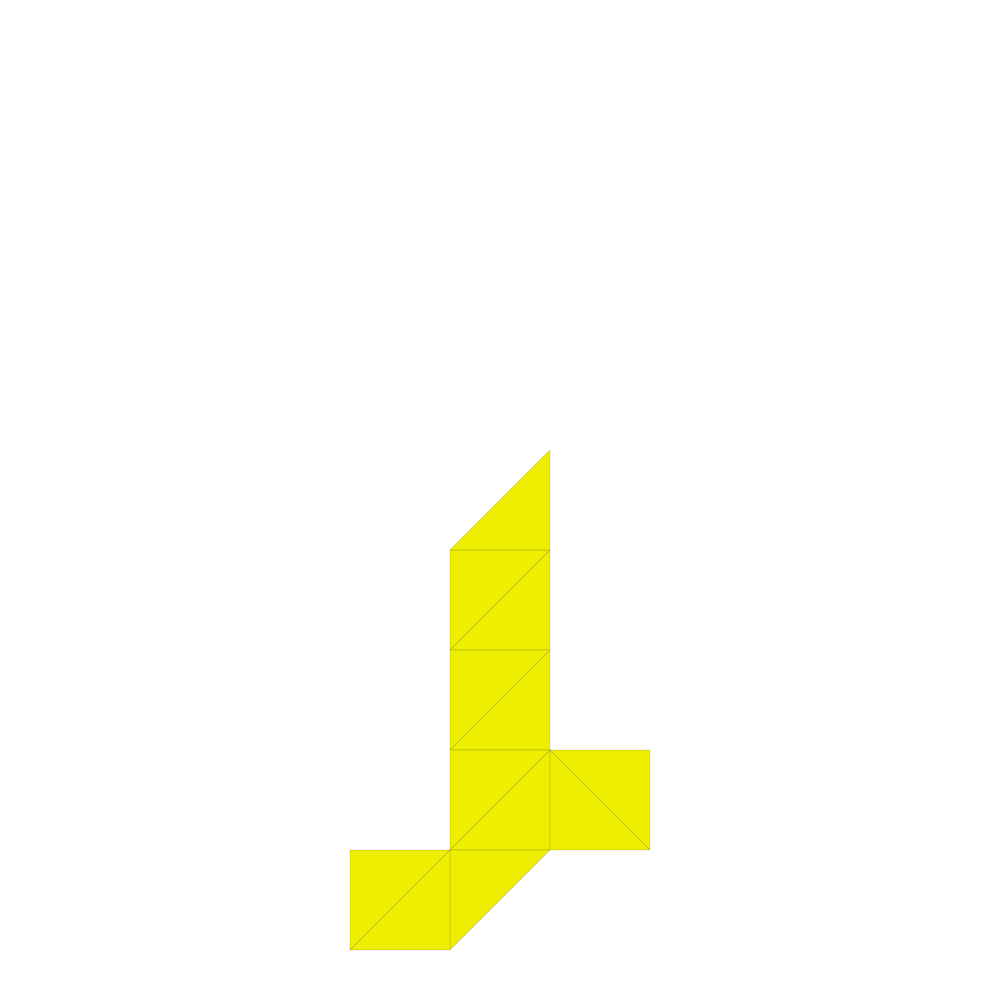

In [12]:
# find commone edge of two adjacent faces
def find_common_edge(faces, face_id_a, face_id_b):
    # make sure that the resulting vertex ids are clockwise wrt. source face
    face_vertex_array_a = faces[face_id_a]
    face_vertex_array_b = faces[face_id_b]

    for i in range(3):
        if face_vertex_array_a[i] in face_vertex_array_b and face_vertex_array_a[(i+1) % 3] in face_vertex_array_b:
            return (face_vertex_array_a[i], face_vertex_array_a[(i+1) % 3])

    return None

def get_face_normal(vertices, faces, face_id):
    face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))
    return face_normals[face_id]

# get angle between the normals of two faces
def dihedral_angle(vertices, faces, face_a_id, face_b_id):
    face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))
    return np.arccos(np.clip(np.dot(face_normals[face_a_id], face_normals[face_b_id]), -1.0, 1.0))

def unfold(vertices, faces):
    polygons = []  # resulting polygons, represented as lists of 2D coordinates

    source_face_id = 0
    parent_dict = nx.dfs_predecessors(graph_from_mesh(faces), source=source_face_id)  # format { node_id: parent_id, ... }
    parent_dict[source_face_id] = None  # add the source face, as networkX is not doing this by default

    for face_id, parent_face_id in parent_dict.items():
        # retrieve the coordinates of current face
        face_coordinates = [vertices[vertex_id] for vertex_id in faces[face_id]]
        
        # iterate over all parents and apply unfolding rotations accordingly
        selected_face_id = face_id
        selected_parent_face_id = parent_face_id

        while selected_face_id != source_face_id:
            # get edge between selected face and parent as tuple of two vertex_ids
            hinge_edge = find_common_edge(faces, selected_parent_face_id, selected_face_id)
            
            # apply unfolding transformation:
            # - all face_coordinates are offset such that the hinge_edge aligns with the origin
            # - then, the rotation around the hinge_edge is performed, such that the selected face
            #   and the parent lay in the same plane
            # - finally, we reverse the offset, such that the face ends up in its original position 
            offset = vertices[hinge_edge[0]]
            rotation_angle = dihedral_angle(
                vertices, faces, selected_face_id, selected_parent_face_id)
            rotation_axis = vertices[hinge_edge[0]] - vertices[hinge_edge[1]]
            rotation_matrix = get_rotation_matrix(rotation_axis, rotation_angle)

            for i in range(3):
                face_coordinates[i] = rotation_matrix.dot(face_coordinates[i] - offset) + offset

            # climbing up the tree
            selected_face_id = selected_parent_face_id
            selected_parent_face_id = parent_dict[selected_parent_face_id]

        # project 3D coordinates into the 2D plane that 
        for i in range(3):
            face_coordinates[i] = get_2d_projection(get_face_normal(vertices, faces, source_face_id)).dot(face_coordinates[i])
            
        polygons.append(face_coordinates)

    return polygons


draw_polygons(unfold(vertices, faces))


In [31]:
mp.plot(vertices, faces)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…